In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm

In [ ]:
df = pd.read_csv("https://github.com/debashish05/Time-Series-Analysis-and-Weather-Forecast-of-Manipur/raw/main/manipur_temperature-2010-2020.csv")

#string to date format
df["Date (YYYY-MM-DD)"] = pd.to_datetime(df['Date (YYYY-MM-DD)'],infer_datetime_format=True)
df = df.set_index(['Date (YYYY-MM-DD)'])
df.head(5)

,Temperature (in Fahrenheit)
Date (YYYY-MM-DD),
2010-01-01,57.2
2010-01-02,57.2
2010-01-03,57.2
2010-01-04,57.2
2010-01-05,59.0


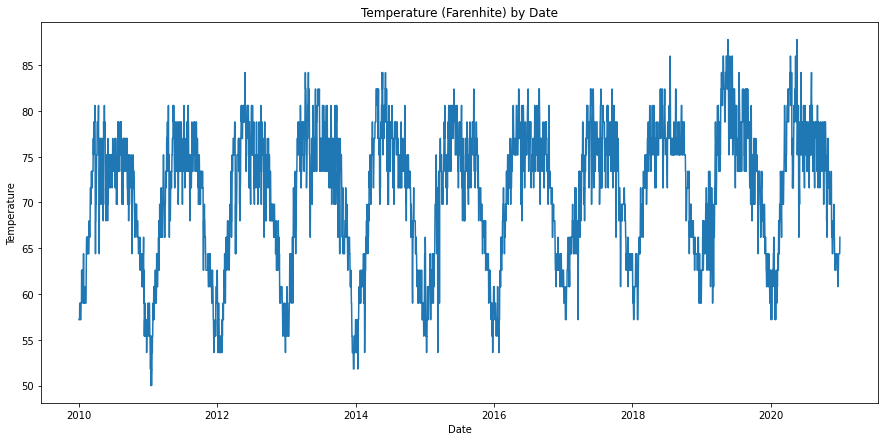

In [ ]:
plt.figure(figsize=(15,7))
plt.title("Temperature (Farenhite) by Date")
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.plot(df)
plt.show()

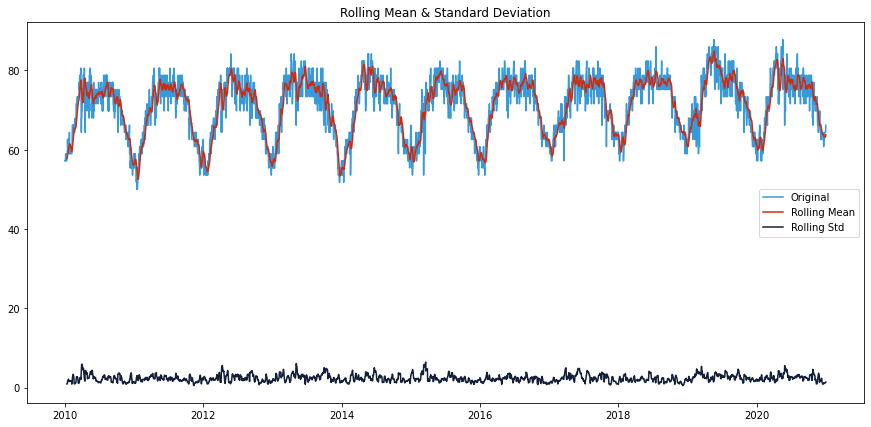

In [ ]:
#Determine rolling statistics
df["rolling_avg"] = df["Temperature (in Fahrenheit)"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["Temperature (in Fahrenheit)"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["Temperature (in Fahrenheit)"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['Temperature (in Fahrenheit)'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -4.188789
p-value                           0.000688
#Lags Used                       24.000000
Number of Observations Used    3993.000000
Critical Value (1%)              -3.431989
Critical Value (5%)              -2.862264
Critical Value (10%)             -2.567155
dtype: float64


In [ ]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df['Temperature (in Fahrenheit)'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

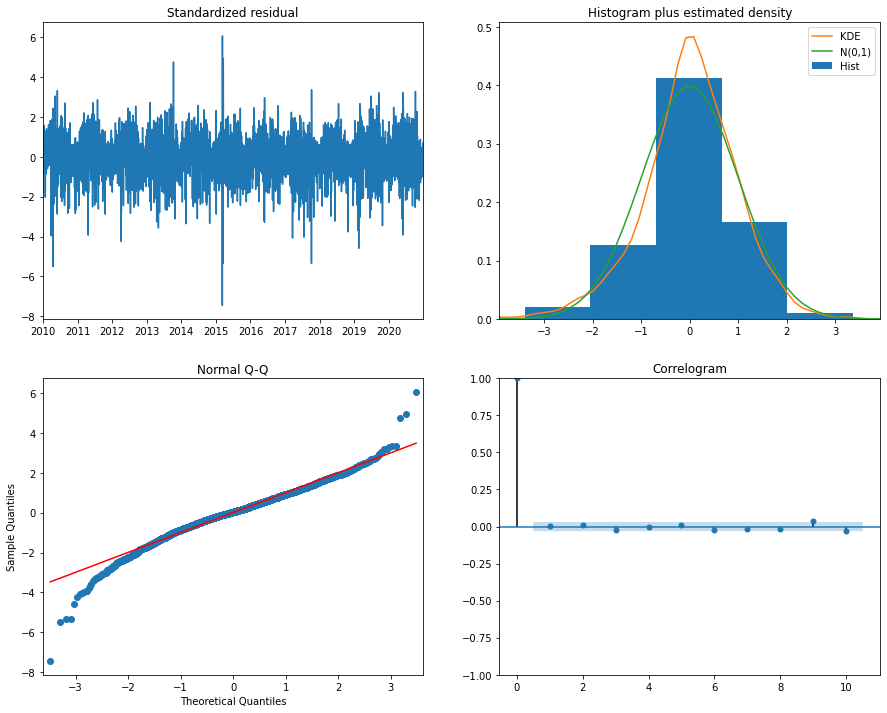

In [ ]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

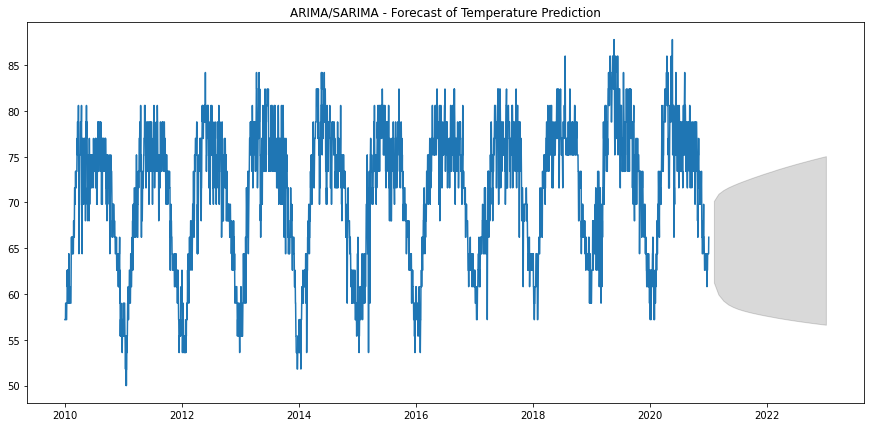

In [ ]:
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["Temperature (in Fahrenheit)"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Temperature Prediction")
    plt.show()

forecast(ARIMA_model)

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
# SARIMA_model = pm.auto_arima(df["Temperature (in Fahrenheit)"], start_p=1, start_q=1,
#                          test='adf',
#                          #max_p=3, max_q=3, 
#                          m=12, #12 is the frequncy of the cycle
#                          start_P=0, 
#                          seasonal=True, #set to seasonal
#                          d=None, 
#                          D=1, #order of the seasonal differencing
#                          trace=False,
#                          error_action='ignore',  
#                          suppress_warnings=True, 
#                          stepwise=True)

In [ ]:
#SARIMA_model.plot_diagnostics(figsize=(15,12))
#plt.show()

In [ ]:
#forecast(SARIMA_model)

In [ ]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df['Temperature (in Fahrenheit)'], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["#Passengers"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline Passengers")
    plt.show()

sarimax_forecast(SARIMAX_model, periods=24)